### Prepare
Check environment. Install packages if in Colab.


In [1]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

import models_mae

### Define utils

In [2]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def img_to_tensor(img):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)
    return x

def postprocess_outputs(y, mask, model):
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    return y, mask


def run_one_image(img, model, mask_ratio=0.75, drop_ratio=0.0):
    x = img_to_tensor(img)
    print(x.shape)

    # run MAE
    loss, y, mask, loss_dropped, y_dropped, mask_dropped = model(x.float(), mask_ratio=mask_ratio, drop_ratio=drop_ratio)
    
    y, mask = postprocess_outputs(y, mask, model)
    y_dropped, mask_dropped = postprocess_outputs(y_dropped, mask_dropped, model)
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(2, 4, 1)
    show_image(x[0], "original")

    plt.subplot(2, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(2, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(2, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    im_masked_dropped = x * (1 - mask_dropped)
    im_paste_dropped = x * (1 - mask_dropped) + y_dropped * mask_dropped

    plt.subplot(2, 4, 5)
    show_image(x[0], "original")

    plt.subplot(2, 4, 6)
    show_image(im_masked_dropped[0], "masked + dropped")

    plt.subplot(2, 4, 7)
    show_image(y_dropped[0], "reconstruction(dropped)")

    plt.subplot(2, 4, 8)
    show_image(im_paste_dropped[0], "reconstruction(dropped) + visible")

    plt.show()

    return loss, loss_dropped

### Load an image

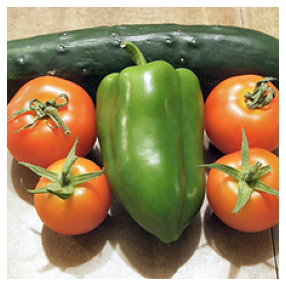

In [3]:
def load_image(img_url):
    img = Image.open(requests.get(img_url, stream=True).raw)
    img = img.resize((224, 224))
    img = np.array(img) / 255.

    assert img.shape == (224, 224, 3)

    # normalize by ImageNet mean and std
    img = img - imagenet_mean
    img = img / imagenet_std
    
    return img
# load an image
img_url1 = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
img_url2 = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851

img1 = load_image(img_url1)
img2 = load_image(img_url2)
plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img1))
show_image(torch.tensor(img2))

### Load a pre-trained MAE model

In [4]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

chkpt_dir = 'mae_visualize_vit_large.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')


File ‘mae_visualize_vit_large.pth’ already there; not retrieving.

<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with pixel reconstruction:
torch.Size([1, 3, 224, 224])


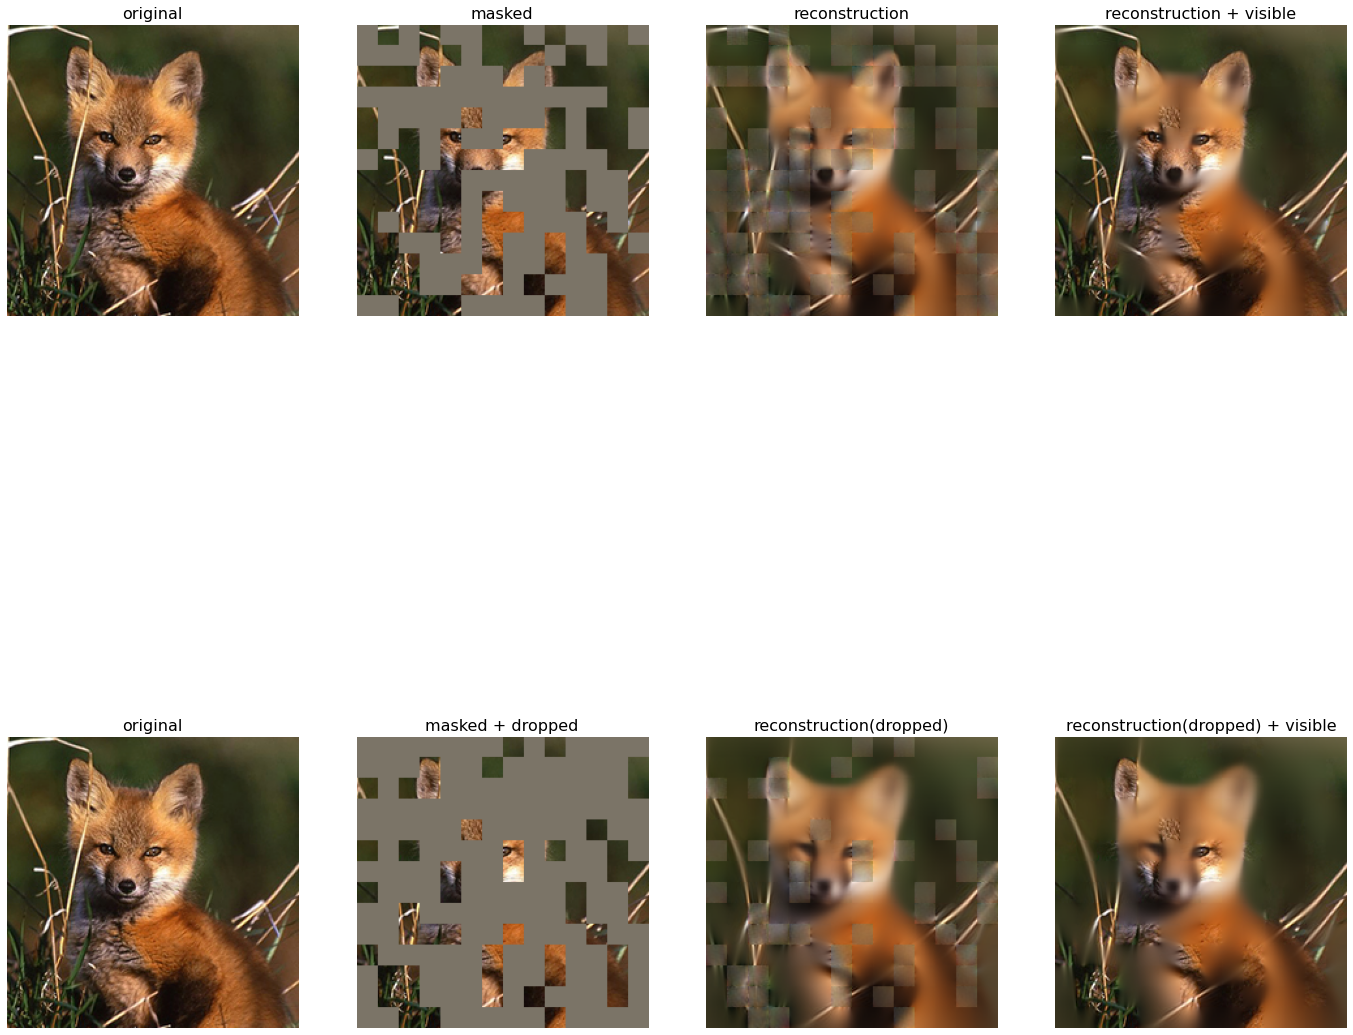

tensor(0.1590, grad_fn=<DivBackward0>) tensor(0.2212, grad_fn=<DivBackward0>)


In [5]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
loss1_list, loss2_list = [], []
loss1_dropped_list, loss2_dropped_list = [], []
print('MAE with pixel reconstruction:')
import models_mae
# for seed in range(1, 10+1):
for seed in range(2, 3):
    # torch.manual_seed(seed)
    loss1, loss1_dropped = run_one_image(img1, model_mae, 0.5, 0.5)
    # loss2, loss2_dropped = run_one_image(img2, model_mae, 0.5, 0.5)
    loss1_list.append(loss1.detach().cpu().numpy())
    # loss2_list.append(loss2.detach().cpu().numpy())
    loss1_dropped_list.append(loss1_dropped.detach().cpu().numpy())
    print(loss1, loss1_dropped)
    # loss2_dropped_list.append(loss2_dropped.detach().cpu().numpy())

    # print('img1 loss: {} img2 loss: {}'.format(loss1, loss2))

    # loss1, loss1_dropped = run_one_image(img1, model_mae, 0.75, 0.0)
    # loss2, loss2_dropped = run_one_image(img2, model_mae, 0.75, 0.0)
    # loss1_list.append(loss1.detach().cpu().numpy())
    # loss2_list.append(loss2.detach().cpu().numpy())
    # loss1_dropped_list.append(loss1_dropped.detach().cpu().numpy())
    # loss2_dropped_list.append(loss2_dropped.detach().cpu().numpy())

    # print('img1 loss: {} img2 loss: {}'.format(loss1, loss2))

torch.Size([1, 3, 224, 224])


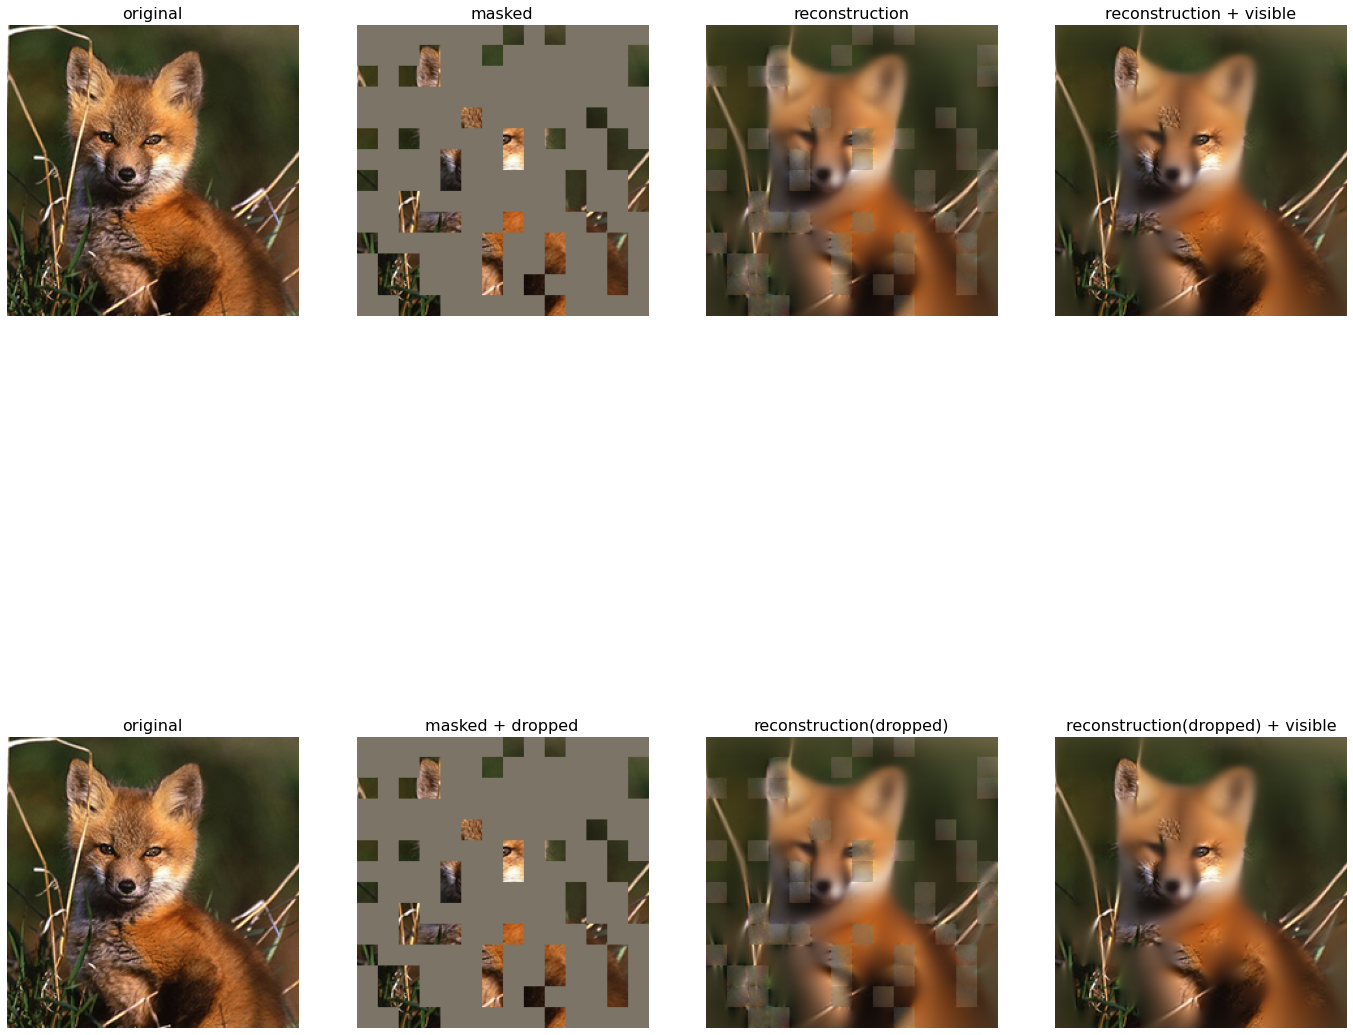

tensor(0.2131, grad_fn=<DivBackward0>) tensor(0.2131, grad_fn=<DivBackward0>)


In [6]:
for seed in range(2, 3):
    torch.manual_seed(seed)
    # loss1, loss1_dropped = run_one_image(img1, model_mae, 0.5, 0.5)
    # loss2, loss2_dropped = run_one_image(img2, model_mae, 0.5, 0.5)
    # loss1_list.append(loss1.detach().cpu().numpy())
    # loss2_list.append(loss2.detach().cpu().numpy())
    # loss1_dropped_list.append(loss1_dropped.detach().cpu().numpy())
    # loss2_dropped_list.append(loss2_dropped.detach().cpu().numpy())

    # print('img1 loss: {} img2 loss: {}'.format(loss1, loss2))

    loss1, loss1_dropped = run_one_image(img1, model_mae, 0.75, 0.0)
    # loss2, loss2_dropped = run_one_image(img2, model_mae, 0.75, 0.0)
    loss1_list.append(loss1.detach().cpu().numpy())
    # loss2_list.append(loss2.detach().cpu().numpy())
    loss1_dropped_list.append(loss1_dropped.detach().cpu().numpy())
    print(loss1, loss1_dropped)
    # loss2_dropped_list.append(loss2_dropped.detach().cpu().numpy())

    # print('img1 loss: {} img2 loss: {}'.format(loss1, loss2))

In [7]:
loss1_arr = np.array(loss1_list)
loss2_arr = np.array(loss2_list)

print(loss1_arr.mean(), loss2_arr.mean())
print(loss1_arr.std(), loss2_arr.std())

0.18604526 nan
0.027089931 nan


/tmp/ipykernel_25115/894619219.py:4: RuntimeWarning: Mean of empty slice.
  print(loss1_arr.mean(), loss2_arr.mean())
/home/suhong/miniconda3/envs/mae/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/suhong/miniconda3/envs/mae/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/suhong/miniconda3/envs/mae/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/suhong/miniconda3/envs/mae/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Sweep over drop ratio

In [ ]:
effective_mask_ratio = 0.75
mask_ratio_range = np.arange(0.0, 0.8, 0.05)
loss1_list = []
loss1_dropped_list = []
import models_mae
for mask_ratio in mask_ratio_range:
    torch.manual_seed(2)
    drop_ratio = (effective_mask_ratio-mask_ratio)/(1-mask_ratio)
    print(drop_ratio)
    loss1, loss1_dropped = run_one_image(img1, model_mae, mask_ratio, drop_ratio)
    loss1_list.append(loss1.detach().cpu().numpy())
    loss1_dropped_list.append(loss1_dropped.detach().cpu().numpy())

    print(loss1, loss1_dropped)

tensor(0.2131, grad_fn=<DivBackward0>)
[0.75       0.73684211 0.72222222 0.70588235 0.6875     0.66666667
 0.64285714 0.61538462 0.58333333 0.54545455 0.5        0.44444444
 0.375      0.28571429 0.16666667 0.        ]
[array(0.21792753, dtype=float32), array(0.21690023, dtype=float32), array(0.21606693, dtype=float32), array(0.2181613, dtype=float32), array(0.21755262, dtype=float32), array(0.21711859, dtype=float32), array(0.21617405, dtype=float32), array(0.21709597, dtype=float32), array(0.21788837, dtype=float32), array(0.22123757, dtype=float32), array(0.2212487, dtype=float32), array(0.21880518, dtype=float32), array(0.21608736, dtype=float32), array(0.21613152, dtype=float32), array(0.2128138, dtype=float32), array(0.21313518, dtype=float32)]


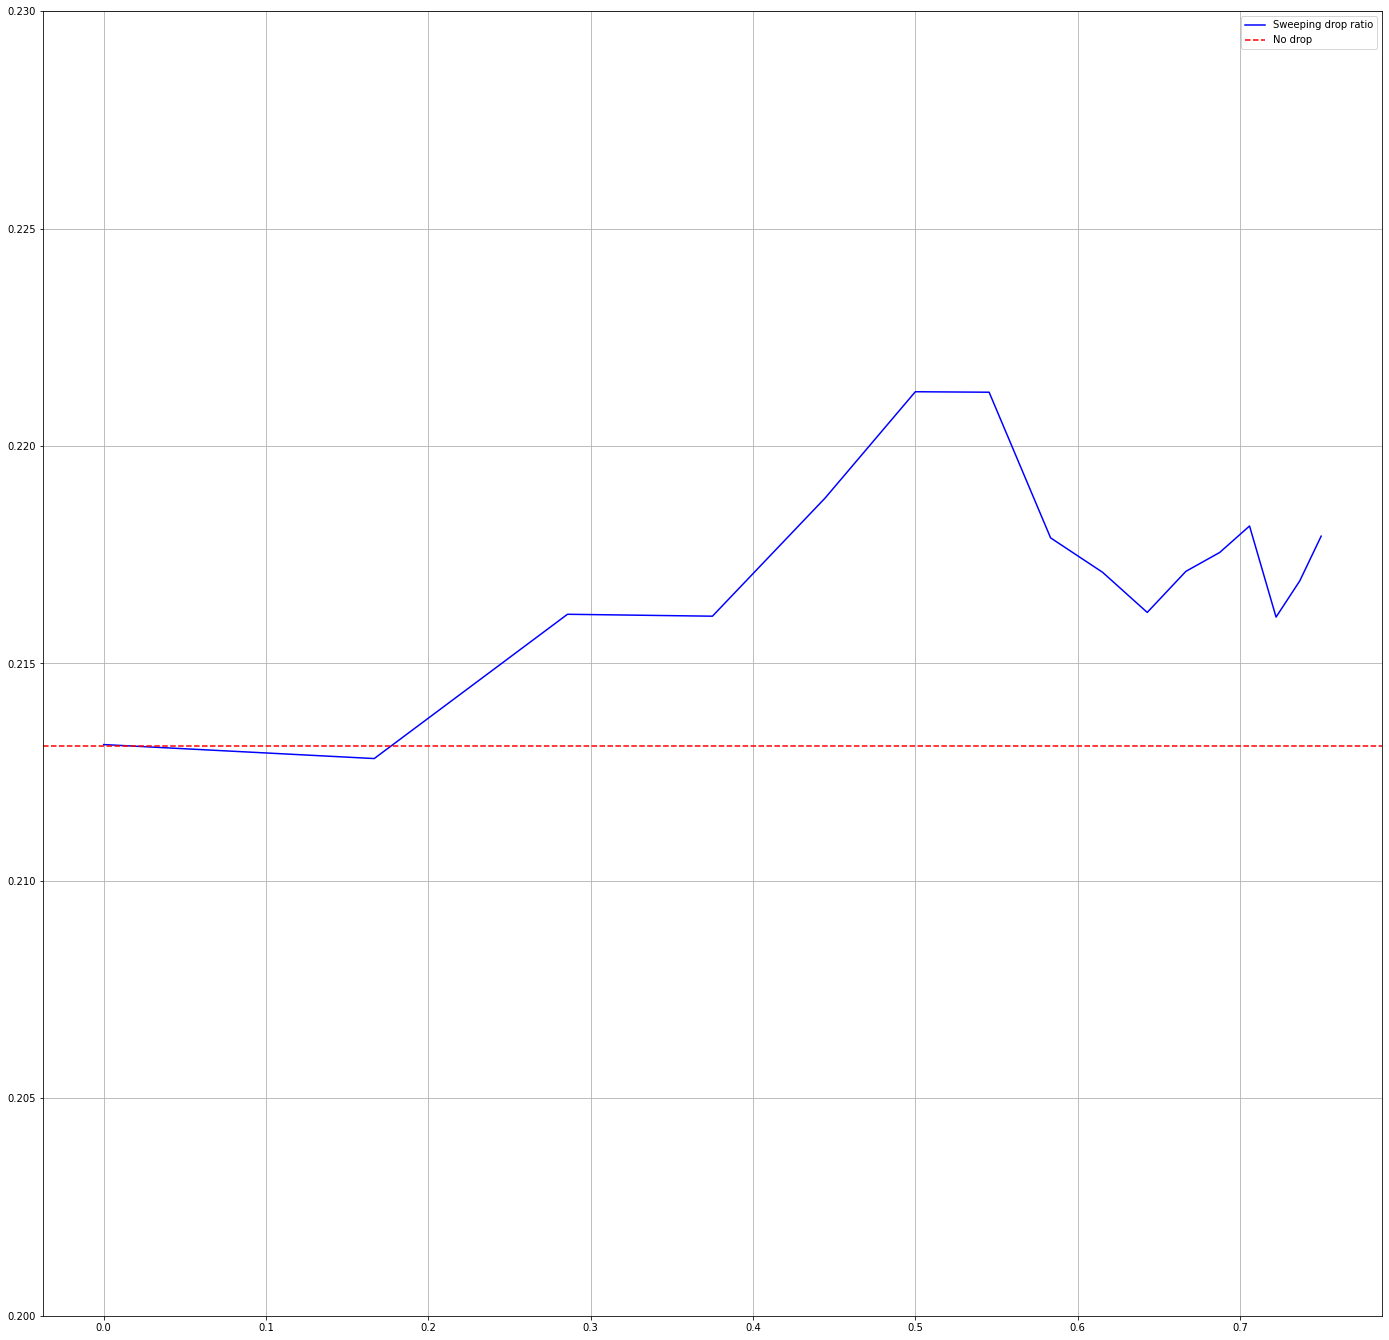

In [21]:
drop_ratio_range = (effective_mask_ratio-mask_ratio_range)/(1-mask_ratio_range)
print(loss1_dropped)
plt.plot(drop_ratio_range, loss1_dropped_list, color='blue', label='Sweeping drop ratio')
plt.axhline(y=0.2131, color='r', linestyle='--', label='No drop')
plt.ylim(0.2, 0.23)
plt.legend()
plt.grid()

### What Kind of Information that Decoder Learns?

In [14]:
torch.manual_seed(2)
print('MAE with pixel reconstruction:')

chkpt_dir = 'mae_visualize_vit_large.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')

def plot_loss_curve(drop_enc_ratio, mask_ratio_range, recon_loss_list, eff_mask_list, dropped_loss_list):
    plt.plot(mask_ratio_range, recon_loss_list, label='No drop')
    plt.plot(eff_mask_list, dropped_loss_list, label='Drop')
    plt.grid()
    plt.legend()
    plt.xticks()
    plt.title(drop_enc_ratio)
    plt.xlabel("Effective masking ratio")
    plt.ylabel("Reconstruction Loss")
    plt.show()

MAE with pixel reconstruction:
<All keys matched successfully>


In [24]:
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
# mask_ratio_range = np.arange(0.05, 1.0, 0.05)
mask_ratio_range = [0.5]
drop_enc_ratio_range = [0.5]
x = img_to_tensor(img1)
for drop_enc_ratio in drop_enc_ratio_range:
    recon_loss_list, dropped_loss_list, eff_mask_list = [], [], []
    print('----------------------------------------')
    print(drop_enc_ratio)
    for mask_ratio in mask_ratio_range:
        loss, y, mask, loss_dropped, y_dropped, mask_dropped = model_mae(x.float(), mask_ratio, drop_enc_ratio)
        recon_loss_list.append(loss.item())
        dropped_loss_list.append(loss_dropped.item())
        effective_masking_ratio = 1-(1-mask_ratio)*(1-drop_enc_ratio)
        eff_mask_list.append(effective_masking_ratio)
        print(mask_ratio, effective_masking_ratio, loss.item())
    plot_loss_curve(drop_enc_ratio, mask_ratio_range, recon_loss_list, eff_mask_list, dropped_loss_list)

MAE with pixel reconstruction:
----------------------------------------
0.75


TypeError: forward() takes from 2 to 3 positional arguments but 4 were given

### Load another pre-trained MAE model

In [7]:
# This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
print('Model loaded.')

--2022-03-30 13:32:01--  https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1318315181 (1.2G) [binary/octet-stream]
Saving to: ‘mae_visualize_vit_large_ganloss.pth’

mae_visualize_vit_l 100%[===================>]   1.23G  43.2MB/s    in 29s     

2022-03-30 13:32:30 (43.7 MB/s) - ‘mae_visualize_vit_large_ganloss.pth’ saved [1318315181/1318315181]

<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with extra GAN loss:


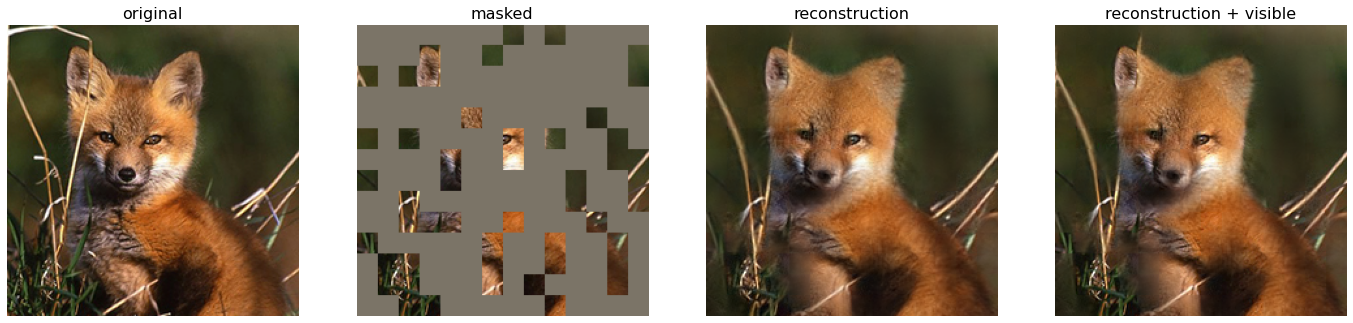

In [8]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with extra GAN loss:')
run_one_image(img, model_mae_gan)